# Hierarchical Star - Spectroscopic Observables

This notebook shows how you can use the `MultieStarModel` to infer stellar parameters with spectroscopic observables effective temperature, surface gravity, and metallicity (`Teff`, `log_g`, `M_H`).

Firstly, import packages.

In [1]:
import json, os
import numpy as np
import pandas as pd
import numpyro, jax
import arviz as az
import matplotlib.pyplot as plt

from matplotlib import colormaps
from pprint import pprint
from corner import corner
from jax import random, vmap
from numpyro import handlers
from numpyro.infer import MCMC, NUTS, Predictive, init_to_median, init_to_value
from numpyro.infer.reparam import LocScaleReparam
from time import time

num_chains = 1
numpyro.enable_x64()
numpyro.set_host_device_count(num_chains)

In [2]:
try:
    gpu = jax.devices('gpu')[0]
except RuntimeError:
    gpu = None

Then, import the `HierarchicalStarModel` from `celestify`.

In [3]:
from celestify.numpyro_models import HierarchicalStarModel

## Truths

Let's synthesis some true parameters for our star from the `SingleStarModel` prior.

In [4]:
directory = "/mnt/data-storage/alexlyttle/scalable-stellar-inference"
filename = "truths-nearest-neighbour-clean.csv"
truths = pd.read_csv(os.path.join(directory, filename), index_col=0)
truths.head()

index  track  star     mass         Y     Zinit     a_MLT  fov_core  \
0  5135942   4716    64  1.21899  0.255556  0.004416  1.789752  0.000315   
1  1047516    572   114  1.18823  0.256612  0.003238  2.030292  0.000000   
2  2374686   2422   832  1.86401  0.255684  0.004760  2.040546  0.014332   
3  4145653   6183   102  0.94165  0.278359  0.022493  1.983209  0.000000   
4  3861544   1731   120  1.15933  0.285274  0.023931  1.880585  0.000000   

   fov_shell      star_age  ...      evol   bol_mag     abs_G    abs_BP  \
0   0.006041  2.053233e+09  ...  0.097247  3.095263  3.064094  3.207612   
1   0.006041  2.775791e+09  ...  0.169591  2.839847  2.821199  2.948562   
2   0.006041  9.790699e+08  ...  0.368276  0.849395  0.779131  1.029182   
3   0.006041  9.238255e+09  ...  0.105998  5.050013  4.977653  5.352141   
4   0.006041  5.699361e+09  ...  0.142149  3.812396  3.704555  4.010748   

     abs_RP          L   log_age       age  log_numax        numax  
0  2.798840   4.590869  0.312438  2.053233   3.253615  1793.142919  
1  2.583362   5.808464  0.443387  2.775791   3.178939  1509.868130  
2  0.371158  36.328047 -0.009186  0.979070   2.295757   197.586545  
3  4.440660   0.758569  0.965590  9.238255   3.503079  3184.777124  
4  3.236899   2.371601  0.755826  5.699361   3.210789  1624.759176  

[5 rows x 42 columns]

In [5]:
num_stars = 50

truths = truths.iloc[:num_stars].to_dict(orient="list")
truths = {key: np.array(value) for key, value in truths.items()}
pprint(truths)

{'Dnu': array([ 86.45678922,  76.78782221,  14.92012567, 138.44730939,
        82.06254291, 148.95871963,  19.36640339,  41.94829275,
       122.60435857,  78.90898055, 190.08492183,  78.82544293,
        63.43382231, 180.85790718,  49.71657861,  28.56353028,
       152.73424301,  89.19107004, 191.83351035,  27.2864407 ,
        36.78600481,  38.1750723 , 136.30285743,  21.35414018,
        17.11955546,  19.63489576,  71.90081199, 142.81127259,
        13.29066473,  51.31352115, 155.16807024,  98.92874687,
        11.14715422,  26.80678209,  36.44177087,  72.80852398,
        22.42825079,  72.28464307,  38.07187603, 190.12530686,
        87.67565682,  22.16384838,  26.86122092,  24.06535675,
        12.48768672,  47.03518073, 126.04528812, 142.22575749,
       151.6776531 ,  60.69045999]),
 'L': array([ 4.59086948,  5.8084644 , 36.32804713,  0.75856871,  2.37160055,
        0.65938767, 10.67163598,  4.15722075,  1.17368795,  3.32136131,
        0.31508938,  4.26172001,  3.97688801,  0.

In [6]:
filename = "truths.json"
hyperparam_names = ["mu_a", "sigma_a", "Y_0", "dY_dZ", "sigma_Y"]

# SAVE TRUTHS
with open(os.path.join(directory, filename), "r") as file:
    s = file.read()
    json_dict = json.loads(s)
    for name in hyperparam_names:
        truths[name] = json_dict[name]

In [7]:
filename = "observables.csv"
obs = pd.read_csv(os.path.join(directory, filename), index_col=0)
obs = obs.iloc[:num_stars].to_dict(orient="list")
obs = {key: np.array(value) for key, value in obs.items()}
pprint(obs)

{'M_H': array([-4.43382561e-01, -6.18704140e-01, -4.01423991e-01,  3.65917236e-01,
        3.43425572e-01,  3.36712152e-01, -8.48467767e-01,  4.61835191e-02,
       -8.10226977e-01,  1.70336202e-01, -1.97698340e-01, -1.68933958e-01,
        2.56154716e-01, -3.73705983e-01,  1.10486731e-01, -1.67128861e-01,
        3.61838162e-01,  1.73987597e-02,  1.43208653e-01,  4.93504614e-01,
       -1.34352714e-01, -2.07918704e-01,  1.52979076e-01,  3.35064620e-01,
       -5.17454386e-01, -1.58187523e-02, -7.71284103e-04, -5.04665434e-01,
       -3.12599421e-01, -9.16488841e-02, -5.95203489e-02,  2.26224124e-01,
        8.02152418e-03, -6.57507420e-01, -8.79825428e-02,  3.28698426e-01,
        1.77786529e-01,  2.93970481e-02,  1.17000841e-01,  3.47241342e-01,
        2.62860417e-01, -4.05187368e-01,  3.35454345e-02, -4.18086827e-01,
        2.91348398e-01,  2.62595832e-01,  2.49102056e-01, -6.74778819e-01,
        2.11189270e-01,  3.47704254e-02]),
 'log_Dnu': array([1.93615437, 1.89112902, 1.1746

## Model

Now, let's create our star model. We need to provide some model constants. These are typically shape parameters for prior distributions. You can see the full `dict` of constants in the `model.const` attribute.

In [8]:
observables = ["log_Teff", "log_L", "log_Dnu"]

# Create dictionary of model constants
const = {
    "M_H": dict(loc=obs["M_H"], scale=obs["sigma_M_H"], low=-0.9, high=0.5),
}

# Create model
model = HierarchicalStarModel(num_stars, observables, const=const)

pprint(model.const)  # check all constants

{'M_H': {'high': 0.5,
         'loc': array([-4.43382561e-01, -6.18704140e-01, -4.01423991e-01,  3.65917236e-01,
        3.43425572e-01,  3.36712152e-01, -8.48467767e-01,  4.61835191e-02,
       -8.10226977e-01,  1.70336202e-01, -1.97698340e-01, -1.68933958e-01,
        2.56154716e-01, -3.73705983e-01,  1.10486731e-01, -1.67128861e-01,
        3.61838162e-01,  1.73987597e-02,  1.43208653e-01,  4.93504614e-01,
       -1.34352714e-01, -2.07918704e-01,  1.52979076e-01,  3.35064620e-01,
       -5.17454386e-01, -1.58187523e-02, -7.71284103e-04, -5.04665434e-01,
       -3.12599421e-01, -9.16488841e-02, -5.95203489e-02,  2.26224124e-01,
        8.02152418e-03, -6.57507420e-01, -8.79825428e-02,  3.28698426e-01,
        1.77786529e-01,  2.93970481e-02,  1.17000841e-01,  3.47241342e-01,
        2.62860417e-01, -4.05187368e-01,  3.35454345e-02, -4.18086827e-01,
        2.91348398e-01,  2.62595832e-01,  2.49102056e-01, -6.74778819e-01,
        2.11189270e-01,  3.47704254e-02]),
         'low': -0.

## Prior Predictive

Sample from the model prior.

In [9]:
num_samples = 1000

rng = random.PRNGKey(0)
rng, key = random.split(rng)

prior_predictive = Predictive(model, num_samples=num_samples)
with jax.default_device(gpu):
    prior = prior_predictive(key)
y = prior.pop("y")
for i, key in enumerate(model.outputs):
    prior[key] = y[..., i]

Let's put the prior samples in an `arviz.InferenceData` class. This makes it easier to plot and save.

In [10]:
coords = {"star": np.arange(num_stars)}
dims = {}
for key, value in prior.items():
    dims[key] = dim = []
    if value.ndim == 1:
        continue
    if value.shape[-1] == num_stars:
        dim.append("star")

data = az.from_numpyro(prior=prior, coords=coords, dims=dims)
data

Inference data with groups:
	> prior

We can plot the prior and overlay the true values with the `corner` package.

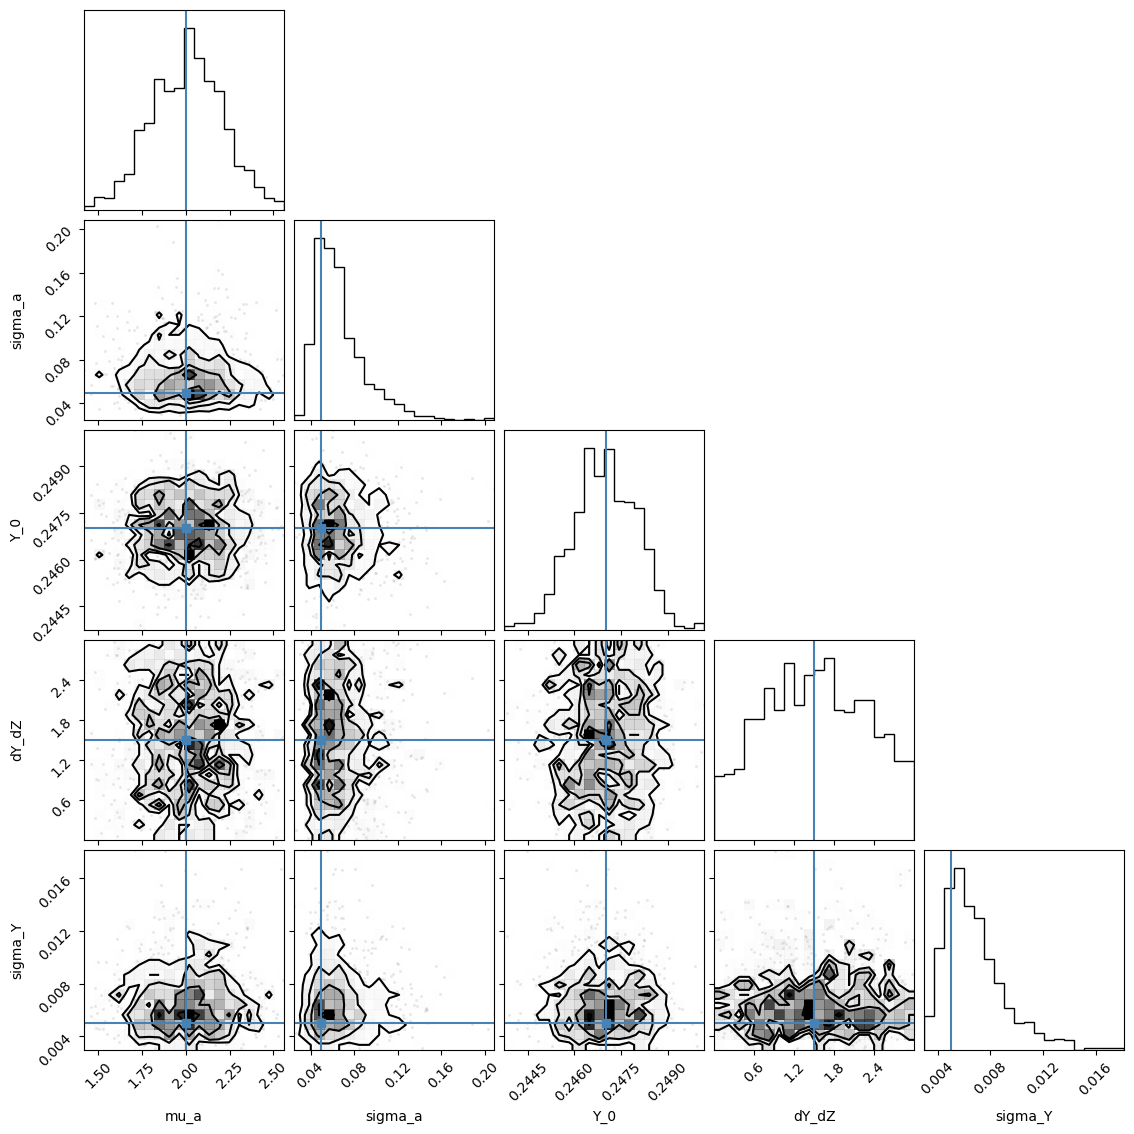

In [11]:
fig = corner(data, group="prior", var_names=hyperparam_names, truths=truths)

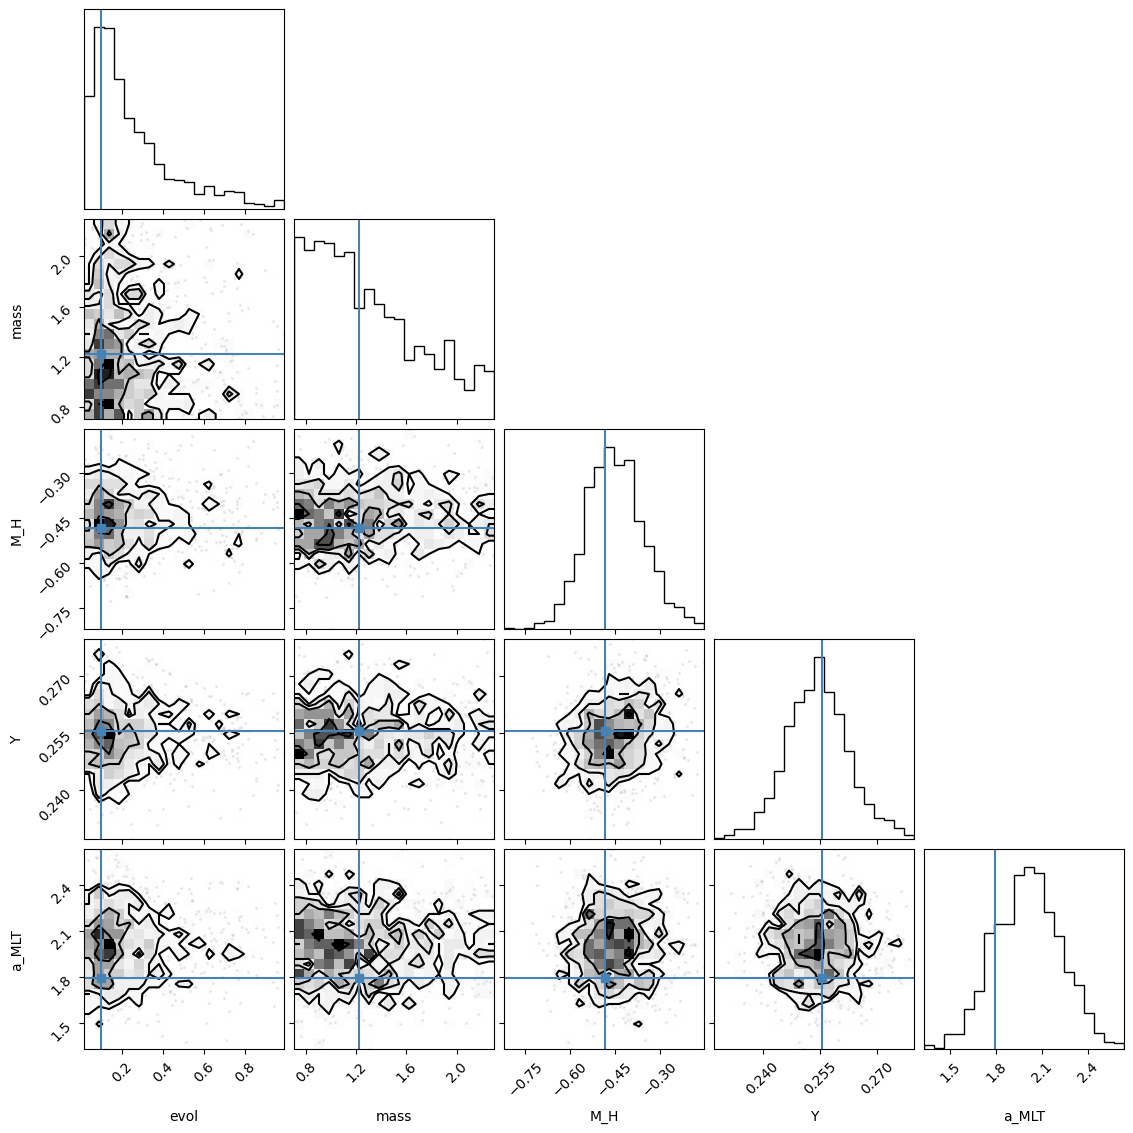

In [12]:
star = 0
var_names = ["evol", "mass", "M_H", "Y", "a_MLT"]
coords_ = {"star": star}
truths_ = {key: truths[key][star] for key in var_names}
fig = corner(data, group="prior", var_names=var_names, truths=truths_, coords=coords_)

Let's also look at some determinisitc parameters in the model.

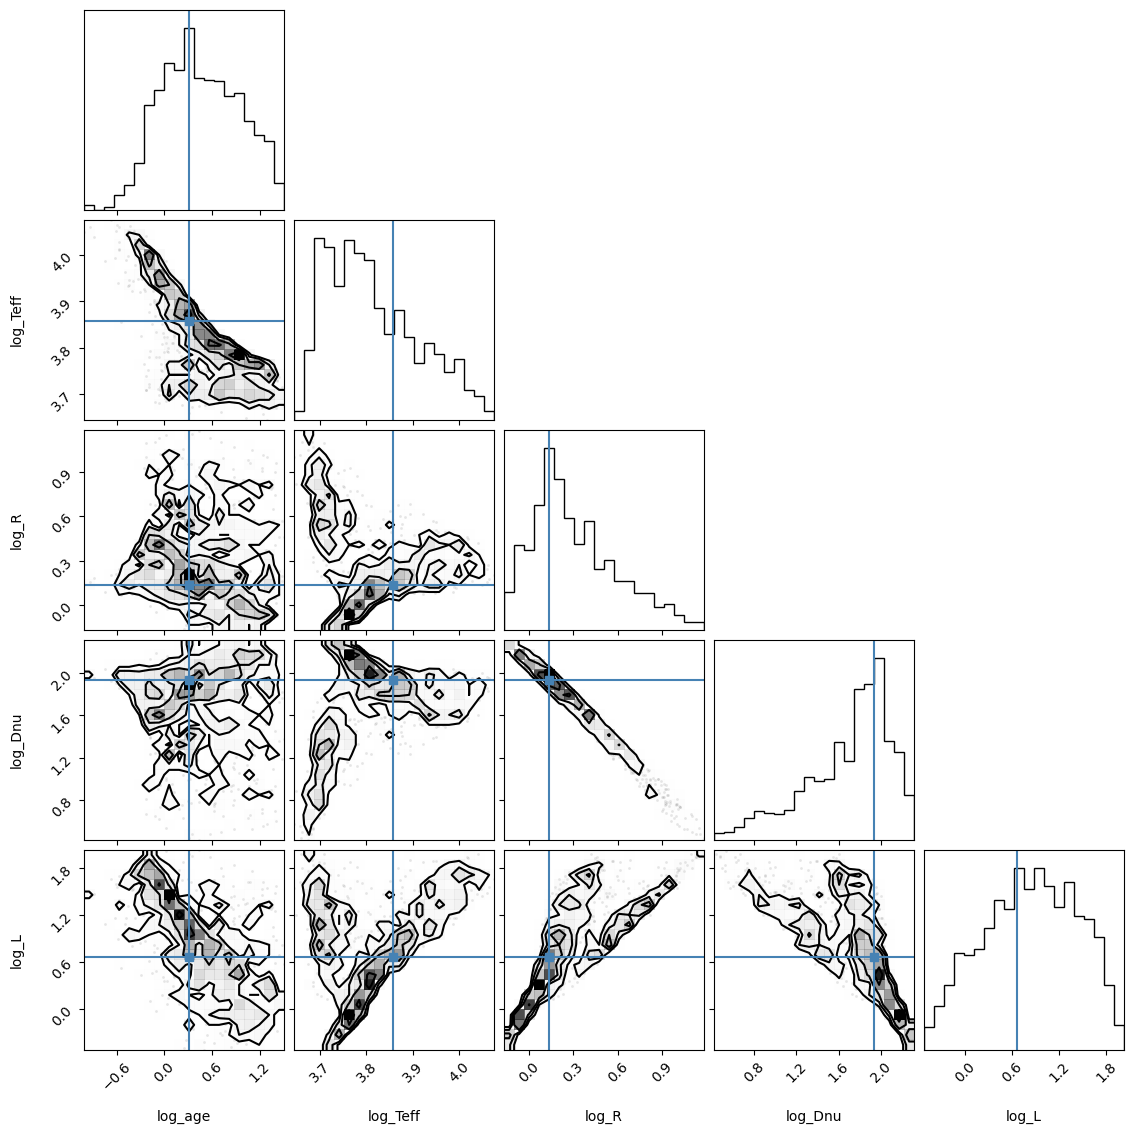

In [13]:
star = 0
var_names = ["log_age", "log_Teff", "log_R", "log_Dnu", "log_L"]
coords_ = {"star": star}
truths_ = {key: truths[key][star] for key in var_names}
fig = corner(data, group="prior", var_names=var_names, truths=truths_, coords=coords_)

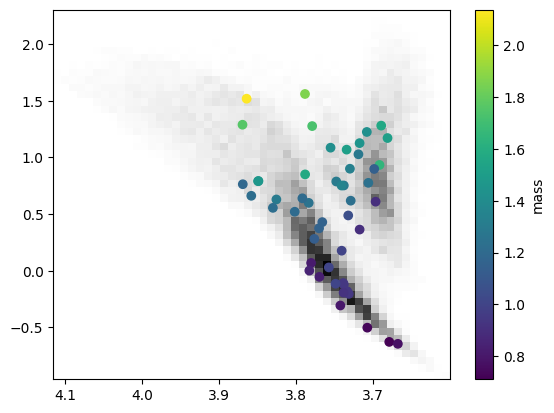

In [14]:
fig, ax = plt.subplots()

ax.hist2d(
    data.prior.log_Teff.values.ravel(), 
    data.prior.log_L.values.ravel(), 
    bins=50, 
    cmap="Grays"
)
s = ax.scatter(
    truths["log_Teff"], 
    truths["log_L"], 
    c=truths["mass"]
)
ax.invert_xaxis()
fig.colorbar(s, label="mass");

## Observation

Now we synthesize observable parameters for the model.

In [15]:
y = np.stack([obs[key] for key in observables], axis=-1)
diag = np.stack([obs[f"sigma_{key}"] for key in observables], axis=-1)**2
pprint(y)
pprint(diag)

array([[ 3.85770369e+00,  6.60382867e-01,  1.93615437e+00],
       [ 3.86248088e+00,  7.57244349e-01,  1.89112902e+00],
       [ 3.79899096e+00,  1.55454350e+00,  1.17468536e+00],
       [ 3.73738289e+00, -1.12409502e-01,  2.14411592e+00],
       [ 3.76501989e+00,  3.75437349e-01,  1.90804684e+00],
       [ 3.73583603e+00, -1.80772036e-01,  2.17448044e+00],
       [ 3.71178794e+00,  1.02577937e+00,  1.28912413e+00],
       [ 3.73503065e+00,  6.18054330e-01,  1.61771584e+00],
       [ 3.77887392e+00,  7.96421319e-02,  2.09161353e+00],
       [ 3.79166603e+00,  5.16690671e-01,  1.89539409e+00],
       [ 3.69791460e+00, -5.07922113e-01,  2.27931309e+00],
       [ 3.82429457e+00,  6.25181317e-01,  1.89087284e+00],
       [ 3.78577232e+00,  5.96310139e-01,  1.80027056e+00],
       [ 3.75163960e+00, -2.94606477e-01,  2.25582886e+00],
       [ 3.73335195e+00,  4.86670673e-01,  1.70215607e+00],
       [ 3.70798540e+00,  6.10511661e-01,  1.45714009e+00],
       [ 3.73443055e+00, -2.02319533e-01

## Sampling

Let's use the No U-Turn Sampler (NUTS) as our Markov Chain Monte Carlo (MCMC) sampling algorithm.

In [16]:
# sampler = NUTS(model, target_accept_prob=0.8, dense_mass=[("dY_dZ", "da_dM", "sigma_Y", "sigma_a")], init_strategy=init_to_median)
# sampler = NUTS(model, target_accept_prob=0.9, init_strategy=init_to_median, find_heuristic_step_size=True, max_tree_depth=11)
num_warmup, num_samples = 3000, 1000

sampler = NUTS(model, target_accept_prob=0.8, init_strategy=init_to_median, find_heuristic_step_size=True)
mcmc = MCMC(sampler, num_warmup=num_warmup, num_samples=num_samples, num_chains=num_chains)

Let's run the MCMC and print a summary of results.

In [17]:
rng, key = random.split(rng)
start = time()
with jax.default_device(gpu):
    mcmc.run(key, obs=y, diag=diag)
elapsed_time = time() - start
mcmc.print_summary()

sample: 100%|██████████| 4000/4000 [50:51<00:00,  1.31it/s, 511 steps of size 6.71e-03. acc. prob=0.82]  



                          mean       std    median      5.0%     95.0%     n_eff     r_hat
              M_H[0]     -0.46      0.09     -0.46     -0.61     -0.32    245.40      1.00
              M_H[1]     -0.57      0.09     -0.57     -0.73     -0.44    223.21      1.03
              M_H[2]     -0.43      0.09     -0.43     -0.58     -0.29    351.70      1.00
              M_H[3]      0.36      0.08      0.36      0.26      0.49    521.17      1.00
              M_H[4]      0.35      0.08      0.35      0.23      0.49    432.89      1.00
              M_H[5]      0.32      0.09      0.32      0.19      0.48    318.89      1.00
              M_H[6]     -0.78      0.07     -0.79     -0.90     -0.68    290.78      1.00
              M_H[7]      0.02      0.10      0.02     -0.13      0.17    194.27      1.00
              M_H[8]     -0.76      0.08     -0.76     -0.88     -0.64    568.54      1.00
              M_H[9]      0.15      0.09      0.14      0.00      0.31    268.48      1.0

Looks pretty good. We want `r_hat` to be close to 1.0 (e.g. less than 1.1). We also want the number of divergances to be very small.

**Note:** The `MultiStarModel` takes longer than running `SingleStarModel` sequentially, but includes population-level priors. It's worth looking at other ways to do this faster.

Let's update our `InferenceData`.

In [18]:
posterior = mcmc.get_samples()

rng, key = random.split(rng)
posterior_predictive = Predictive(model, posterior_samples=posterior, parallel=True, return_sites=["y"])
y = posterior_predictive(key)["y"]

for i, key in enumerate(model.outputs):
    posterior[key] = y[..., i]

posterior = {k: v.reshape((num_chains, num_samples, -1)).squeeze() for k, v in posterior.items()}

In [19]:
sample_stats = mcmc.get_extra_fields(group_by_chain=True)

In [24]:
dims

{'M_H': ['star'],
 'Y': ['star'],
 'Y_0': [],
 'Y_decentered': ['star'],
 'a_MLT': ['star'],
 'a_decentered': ['star'],
 'dY_dZ': [],
 'evol': ['star'],
 'log_evol': ['star'],
 'log_mass': ['star'],
 'mass': ['star'],
 'mu_a': [],
 'precision_Y': [],
 'precision_a': [],
 'scaled_precision': ['star'],
 'sigma_Y': [],
 'sigma_a': [],
 'log_age': ['star'],
 'log_Teff': ['star'],
 'log_R': ['star'],
 'log_Dnu': ['star'],
 'log_L': ['star'],
 'log_g': ['star'],
 'log_numax': ['star']}

In [26]:
with jax.default_device(gpu):
    # data += az.from_dict(posterior=posterior, sample_stats=sample_stats, coords=coords, dims=dims)
    data += az.from_numpyro(mcmc, coords=coords, dims=dims)
data

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> prior
	> observed_data

With `arviz`, we can create a summary of the data.

In [27]:
summary = az.summary(data, fmt="xarray")
summary

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


<xarray.Dataset>
Dimensions:           (star: 50, metric: 9)
Coordinates:
  * star              (star) int64 0 1 2 3 4 5 6 7 8 ... 42 43 44 45 46 47 48 49
  * metric            (metric) <U9 'mean' 'sd' 'hdi_3%' ... 'ess_tail' 'r_hat'
Data variables: (12/17)
    M_H               (metric, star) float64 -0.4563 -0.5719 -0.4344 ... nan nan
    Y                 (metric, star) float64 0.2559 0.2537 0.2578 ... nan nan
    Y_0               (metric) float64 0.247 0.001007 0.2452 ... 953.9 nan
    Y_decentered      (metric, star) float64 -0.0005504 -0.009338 ... nan nan
    a_MLT             (metric, star) float64 2.04 2.039 2.032 ... nan nan nan
    a_decentered      (metric, star) float64 0.02704 0.01128 -0.1004 ... nan nan
    ...                ...
    mu_a              (metric) float64 2.038 0.06181 1.921 ... 24.55 50.83 nan
    precision_Y       (metric) float64 3.265e+04 1.658e+04 ... 81.14 nan
    precision_a       (metric) float64 352.8 169.3 61.68 ... 102.9 153.6 nan
    scaled_precision  (metric, star) float64 1.025 1.052 0.9838 ... nan nan nan
    sigma_Y           (metric) float64 0.006196 0.002015 0.003553 ... 81.14 nan
    sigma_a           (metric) float64 0.05843 0.01585 0.03394 ... 153.6 nan

In [28]:
summary_nan = summary.where(summary.sel(metric="r_hat") < 1.1).to_array()
summary_nan

<xarray.DataArray (variable: 17, metric: 9, star: 50)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * star      (star) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
  * metric    (metric) <U9 'mean' 'sd' 'hdi_3%' ... 'ess_tail' 'r_hat'
  * variable  (variable) object 'M_H' 'Y' 'Y_0' ... 'sigma_Y' 'sigma_a'

In [29]:
summary_stacked = summary_nan.stack(x=["variable", "metric", "star"])
null_coords = summary_stacked[summary_stacked.isnull()].coords
bad_stars = set(null_coords["star"].values)
print(bad_stars)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49}


In [30]:
efficiency = summary.sel(metric="ess_bulk") / elapsed_time

In [31]:
values = []
for value in efficiency.values():
    values.append(np.atleast_1d(value))

eff = np.concatenate(values)

Text(0, 0.5, 'Count')

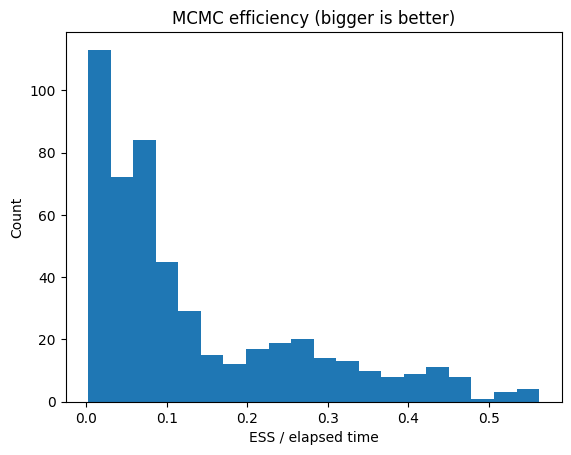

In [32]:
fig, ax = plt.subplots()

ax.hist(eff, bins=20)
ax.set_title("MCMC efficiency (bigger is better)")
ax.set_xlabel("ESS / elapsed time")
ax.set_ylabel("Count")

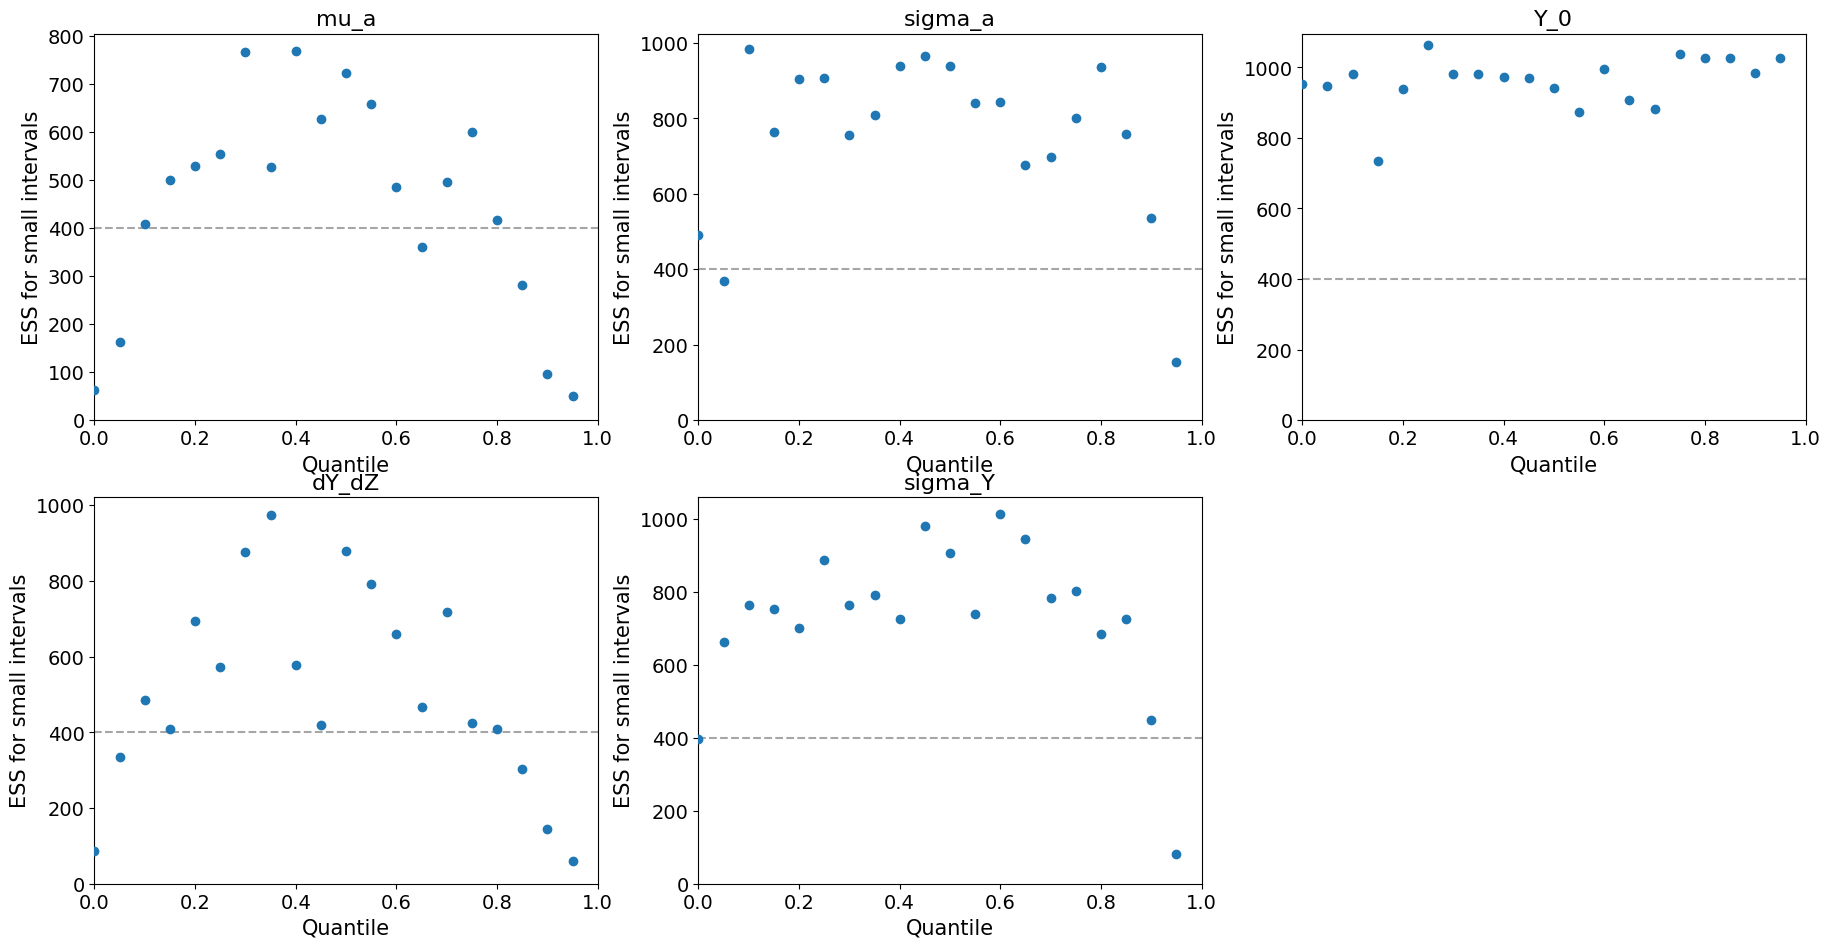

In [33]:
az.plot_ess(data, var_names=hyperparam_names);

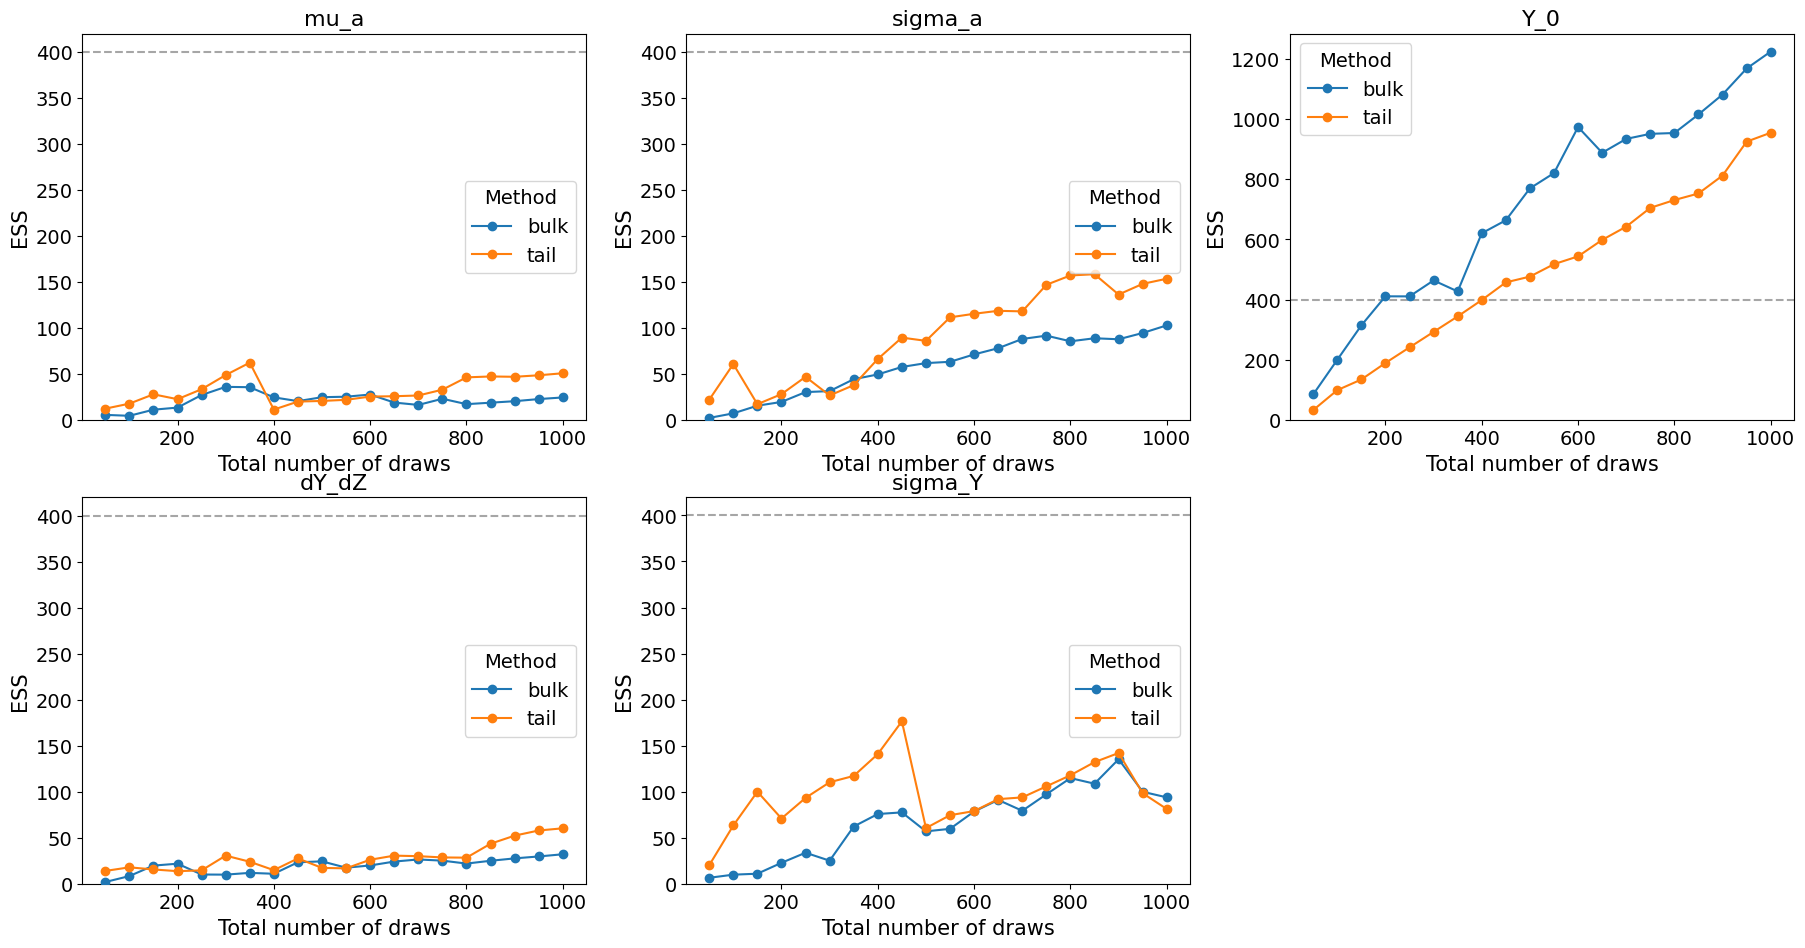

In [34]:
az.plot_ess(data, kind="evolution", var_names=hyperparam_names);

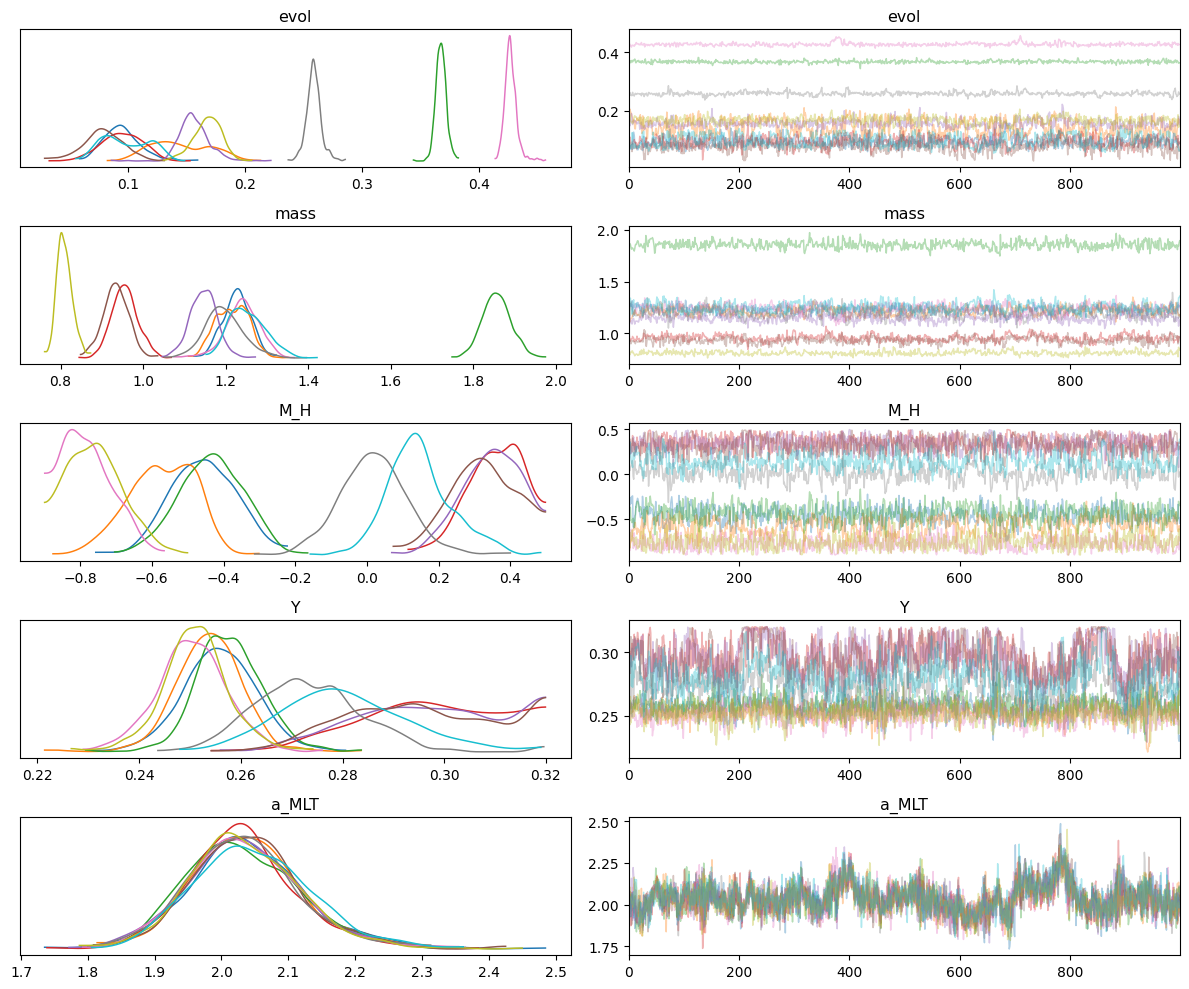

In [35]:
var_names = ["evol", "mass", "M_H", "Y", "a_MLT"]
az.plot_trace(data, var_names=var_names, coords=dict(star=range(min(num_stars, 10))))
plt.tight_layout()

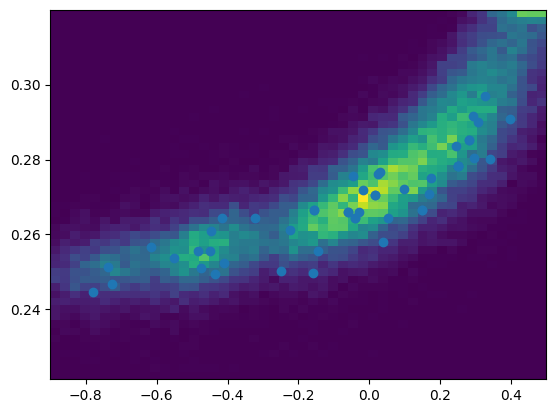

In [36]:
mh = data.posterior.M_H.values.flatten()
y = data.posterior.Y.values.flatten()
plt.hist2d(mh, y, bins=50)
plt.scatter(truths["M_H"], truths["Y"]);

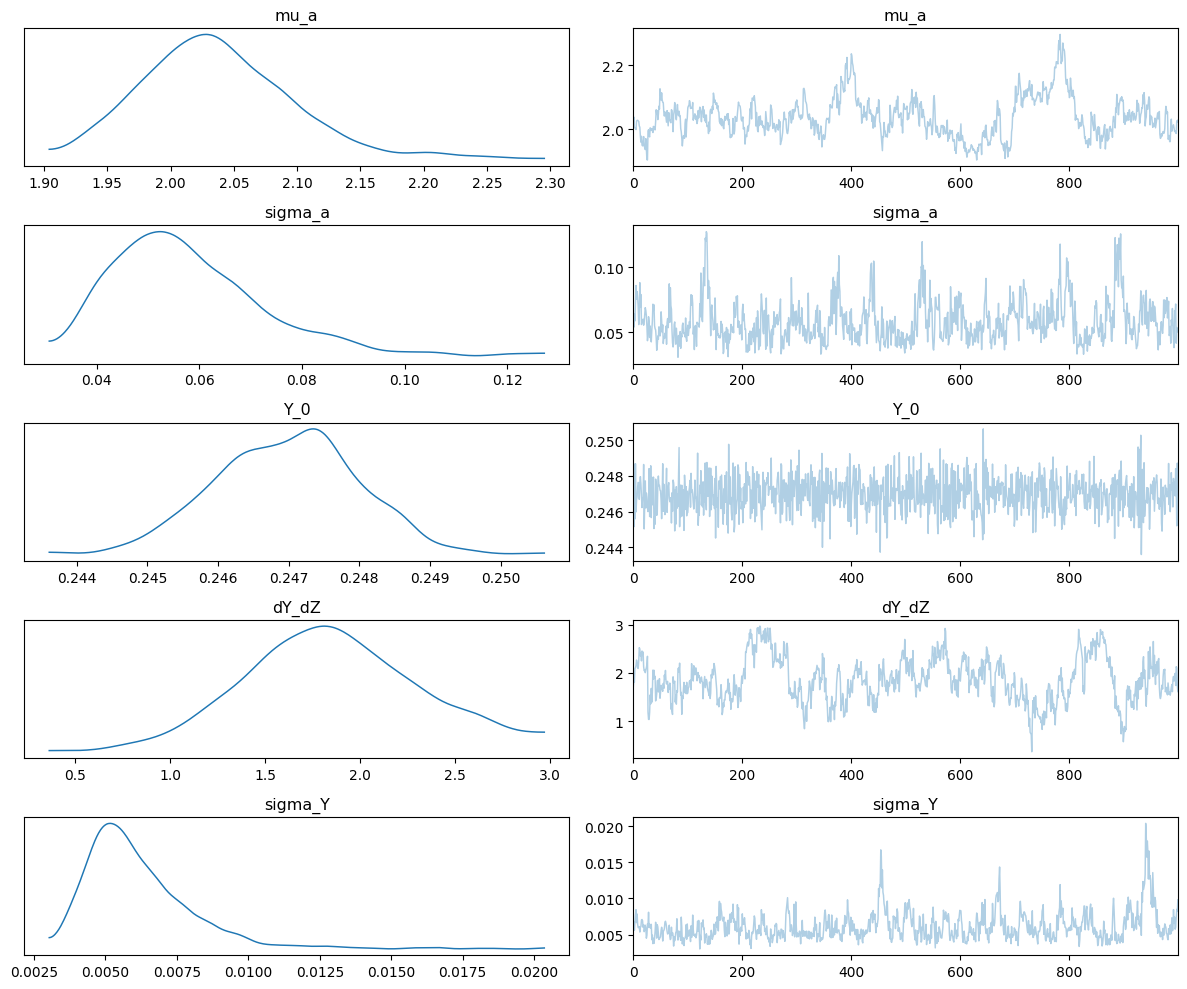

In [37]:
az.plot_trace(data, var_names=hyperparam_names)
plt.tight_layout()

## Posterior Predictive

Let's check the joint posterior distributions and compare with the truth values.

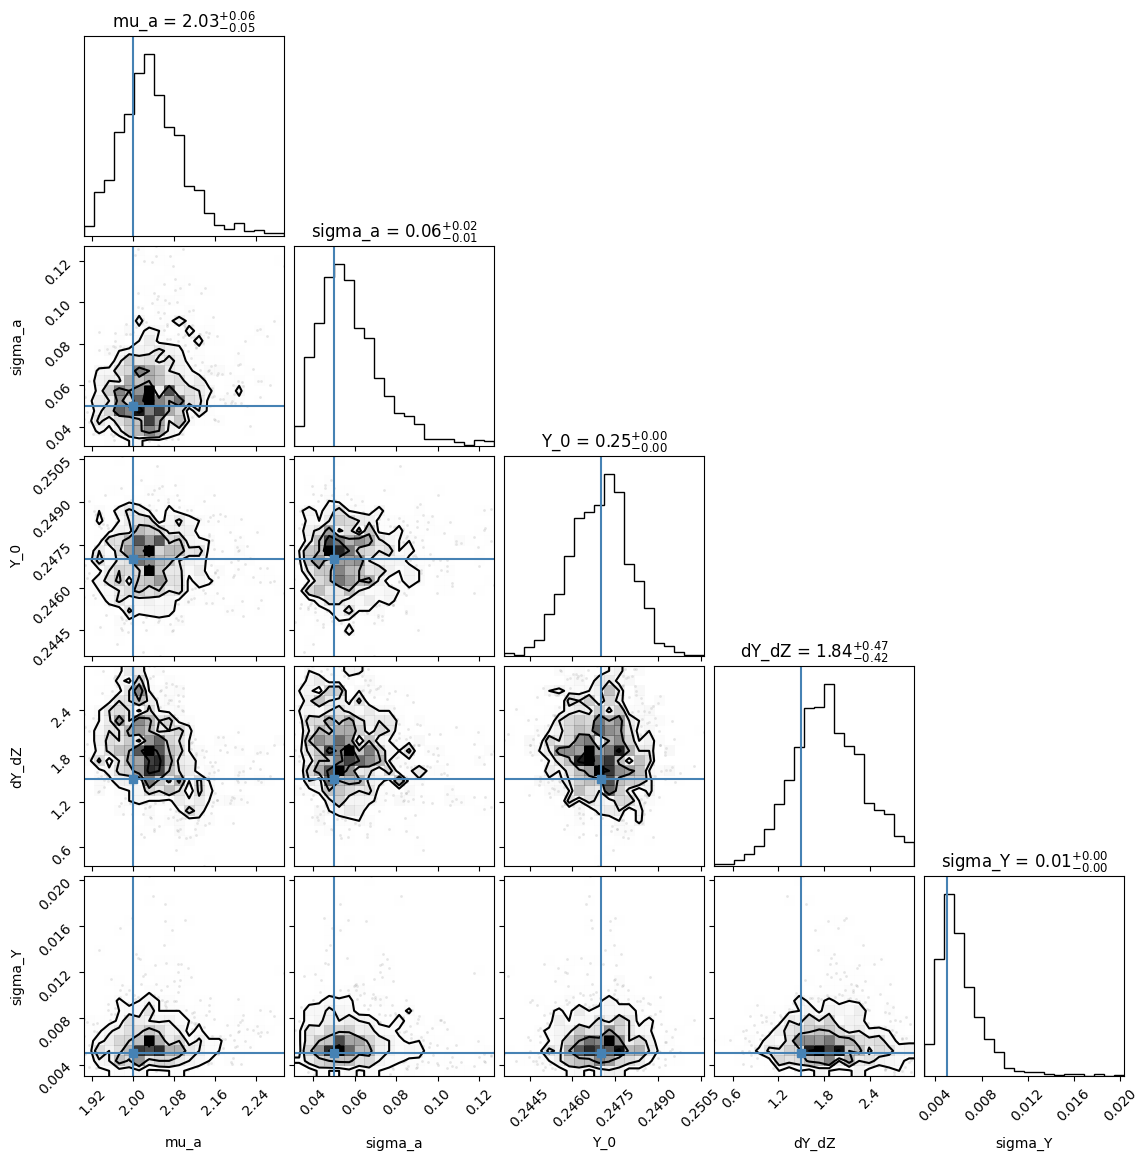

In [38]:
fig = corner(data, group="posterior", var_names=hyperparam_names, truths=truths, show_titles=True)

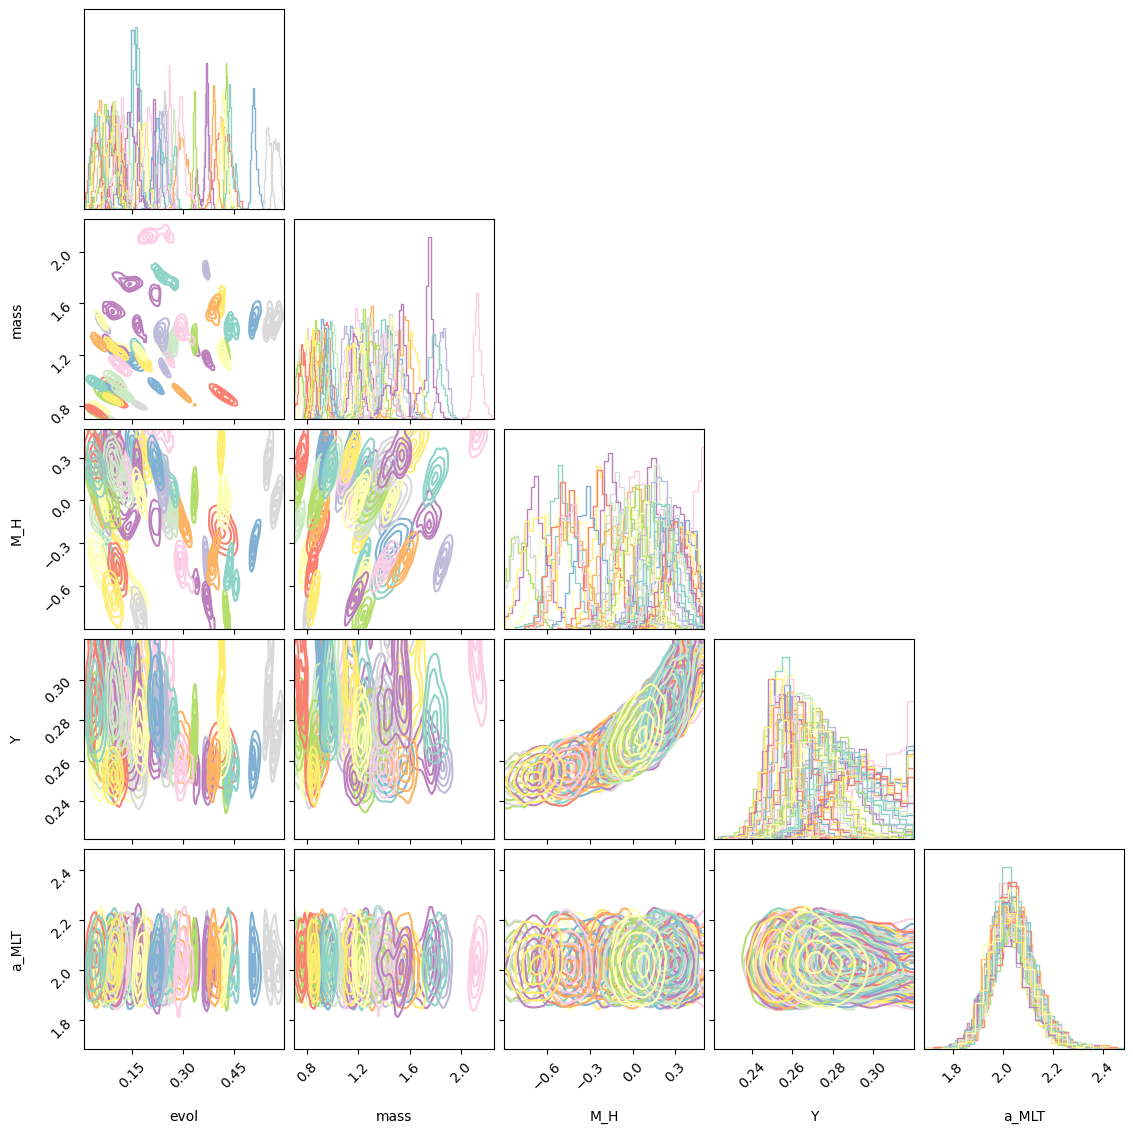

In [39]:
var_names = ["evol", "mass", "M_H", "Y", "a_MLT"]
max_stars = num_stars
cmap = colormaps["Set3"]
fig = None
for star in range(num_stars):
    coords_ = {"star": star}
    color = cmap(star%cmap.N)  # loop colors
    fig = corner(data, var_names=var_names, coords=coords_, color=color, fig=fig,
                 plot_datapoints=False, plot_density=False, smooth=1.0)

In [40]:
var_names = ["log_age", "log_Teff", "log_R", "log_Dnu", "log_L"]
max_stars = num_stars
cmap = colormaps["Set3"]
fig = None
for star in range(max_stars):
    coords_ = {"star": star}
    color = cmap(star%cmap.N)  # loop colors
    fig = corner(data, var_names=var_names, coords=coords_, color=color, fig=fig,
                 plot_datapoints=False, plot_density=False, smooth=1.0)

KeyError: 'var names: "[\'log_age\' \'log_Teff\' \'log_R\' \'log_Dnu\' \'log_L\'] are not present" in dataset'

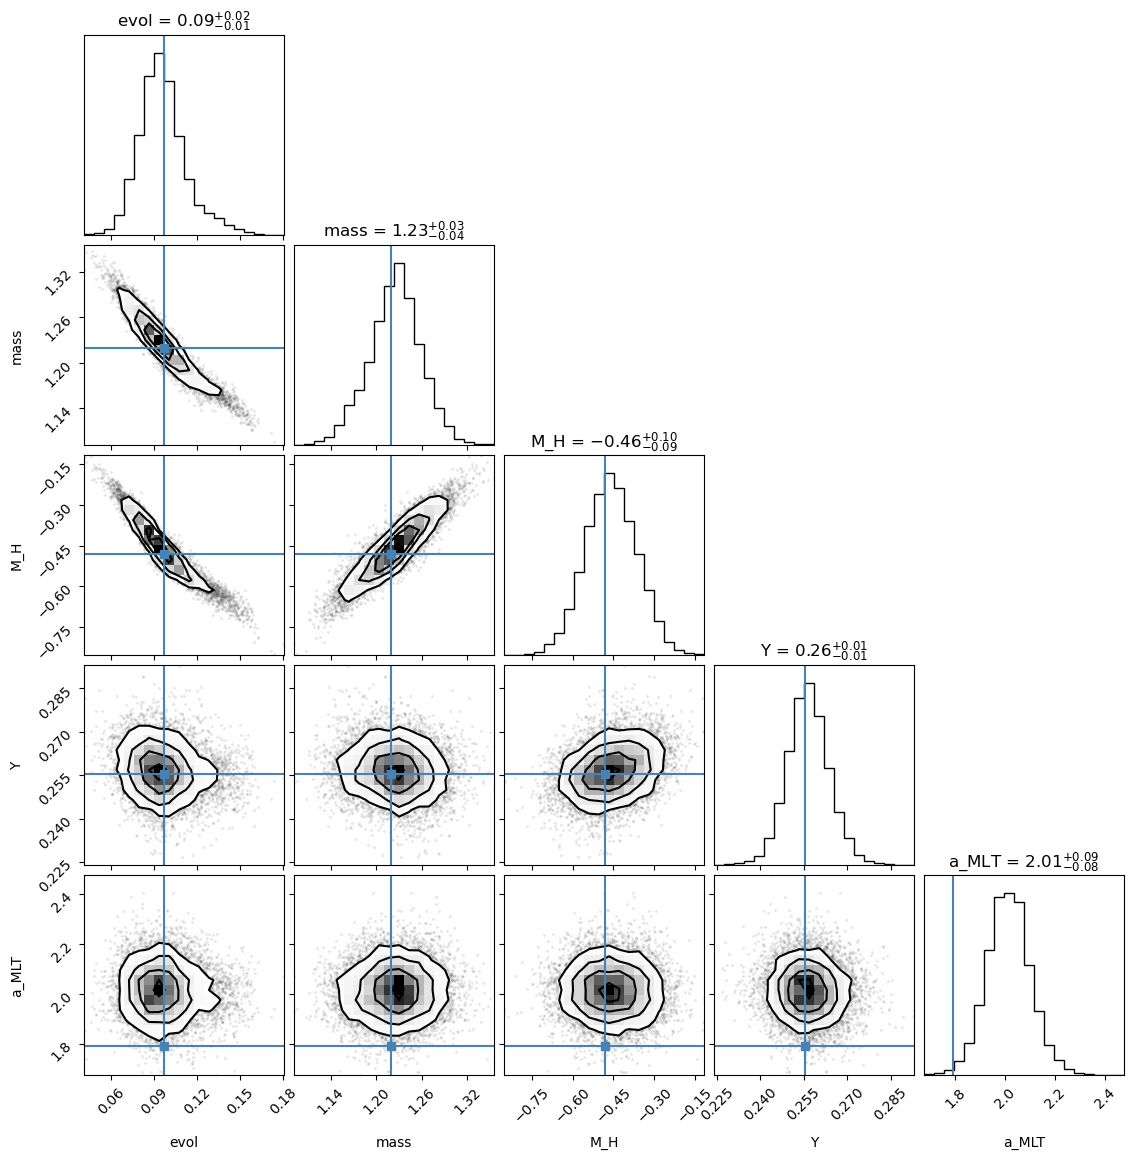

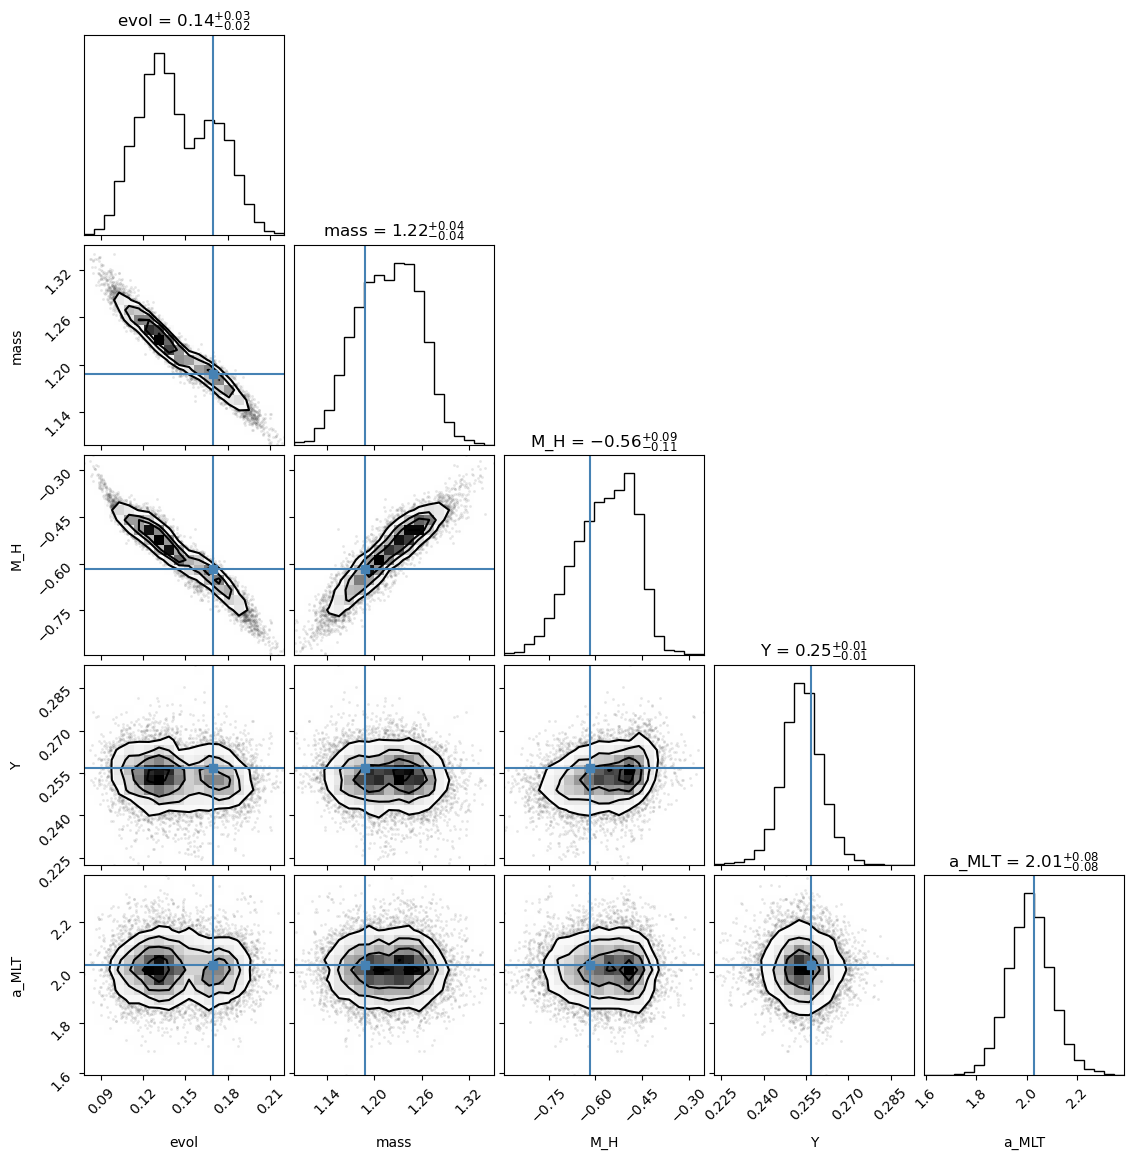

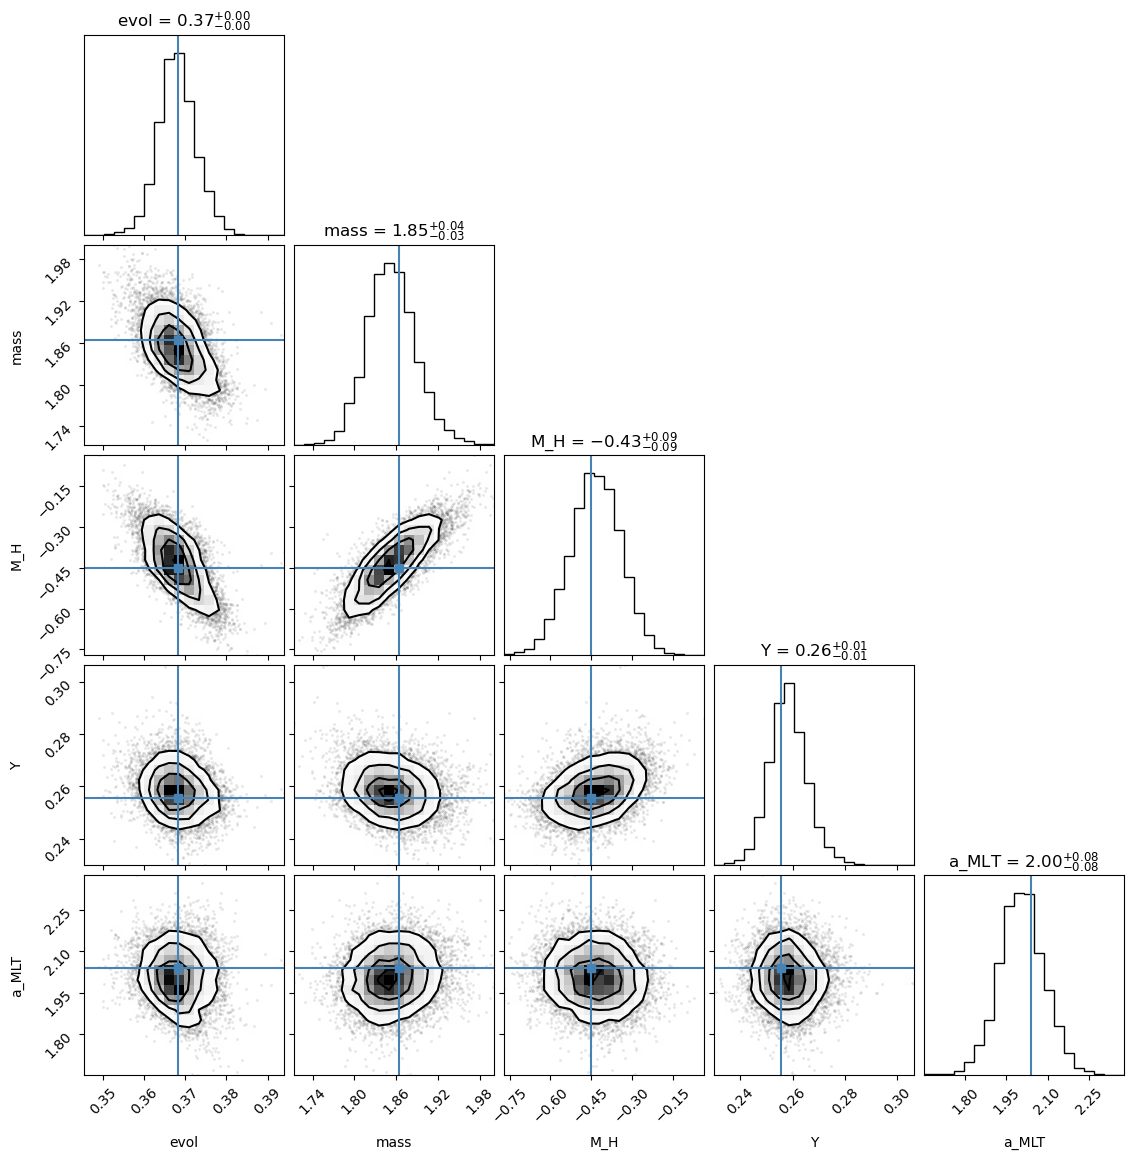

In [ ]:
var_names = ["evol", "mass", "M_H", "Y", "a_MLT"]
for star in range(3):
    coords_ = {"star": star}
    truths_ = {key: truths[key][star] for key in var_names}
    fig = corner(data, group="posterior", var_names=var_names, truths=truths_, coords=coords_, show_titles=True)

What do we predict for some deterministics?

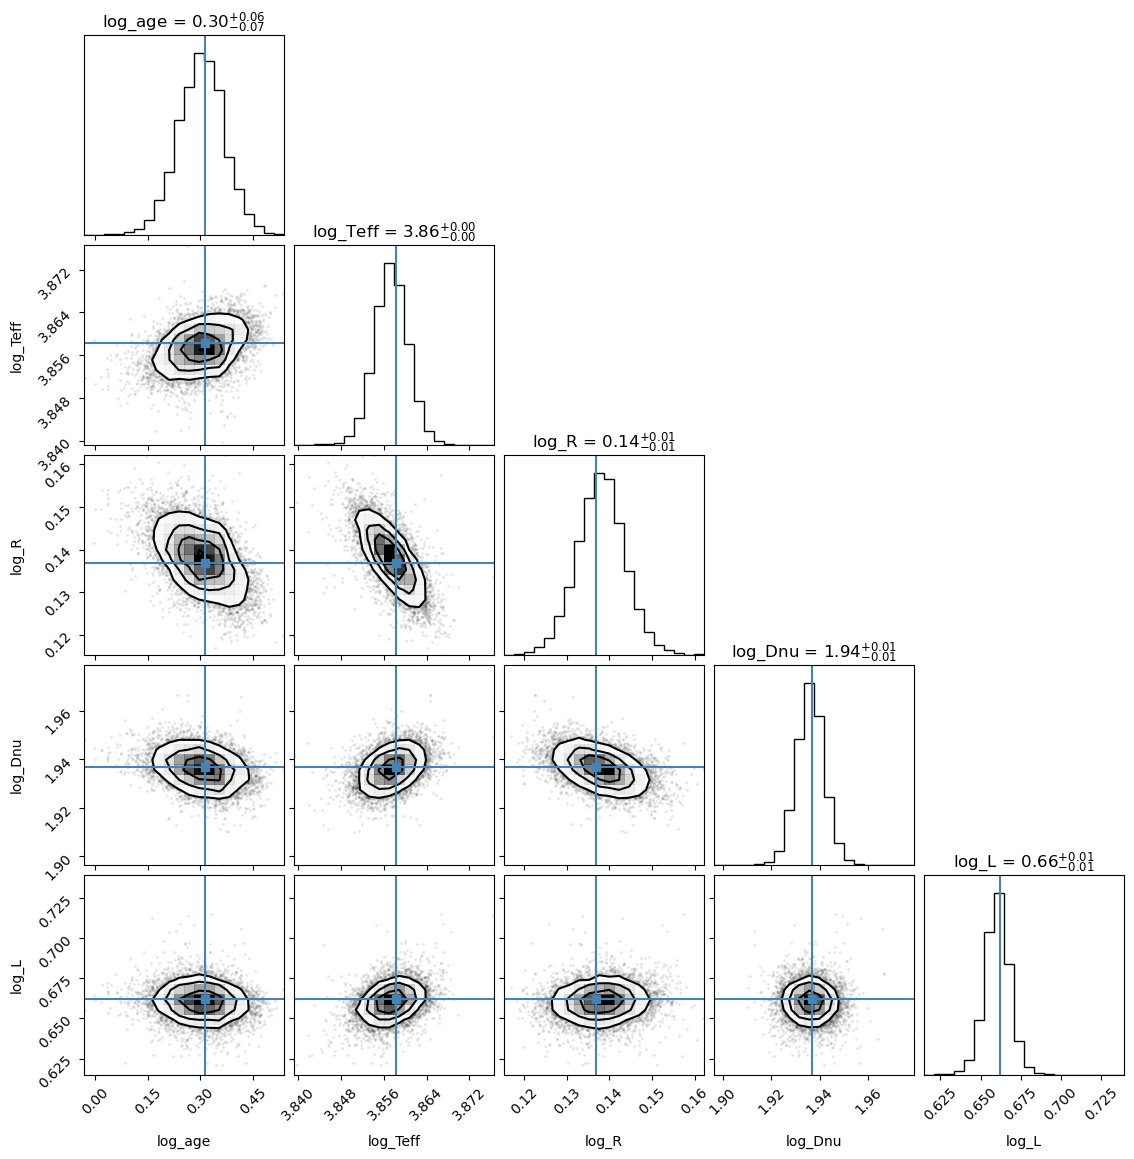

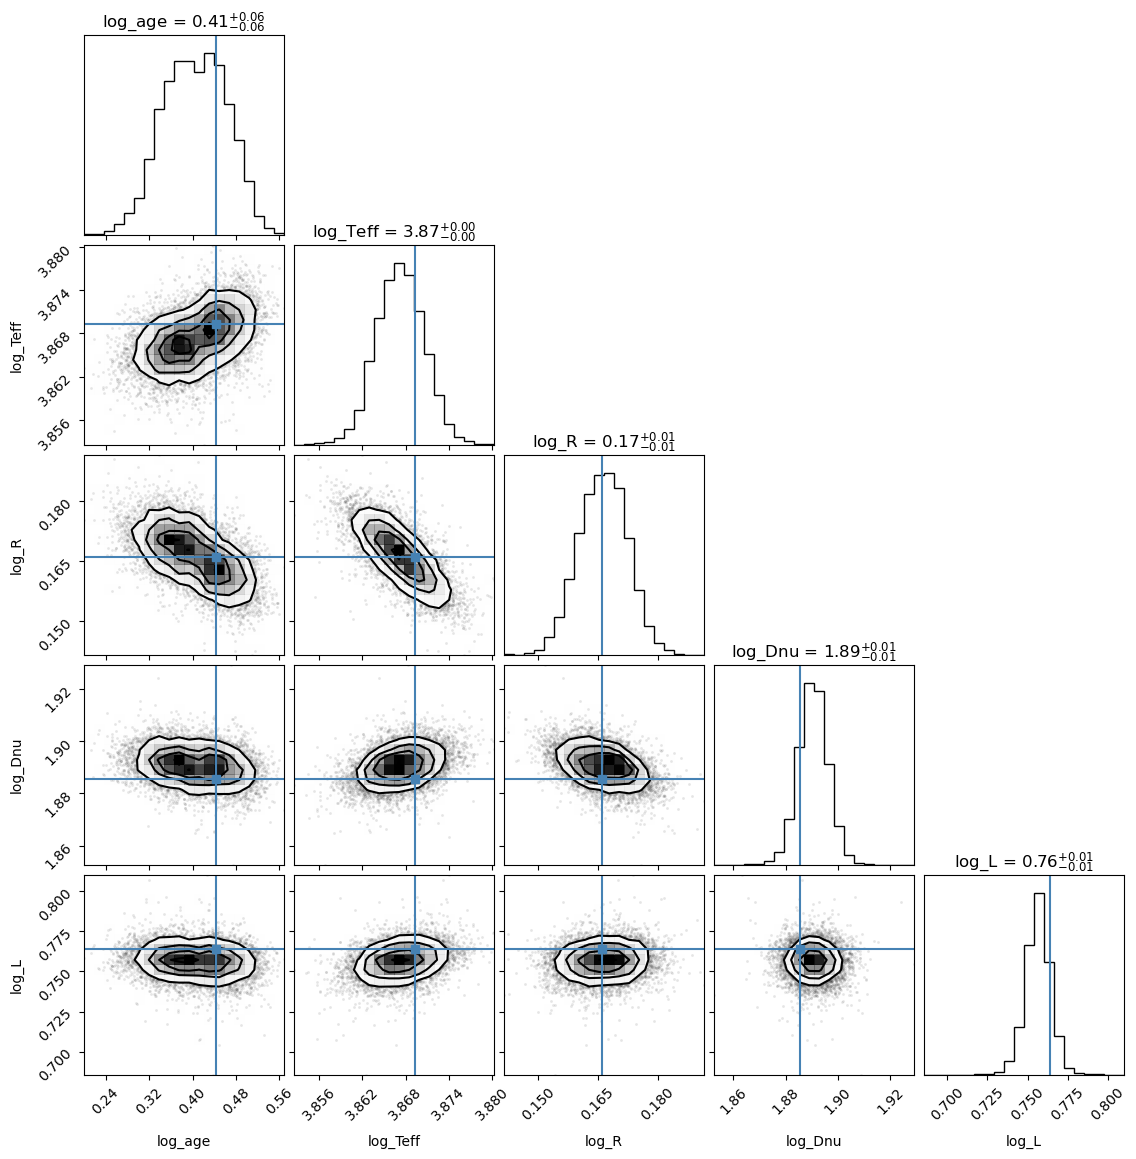

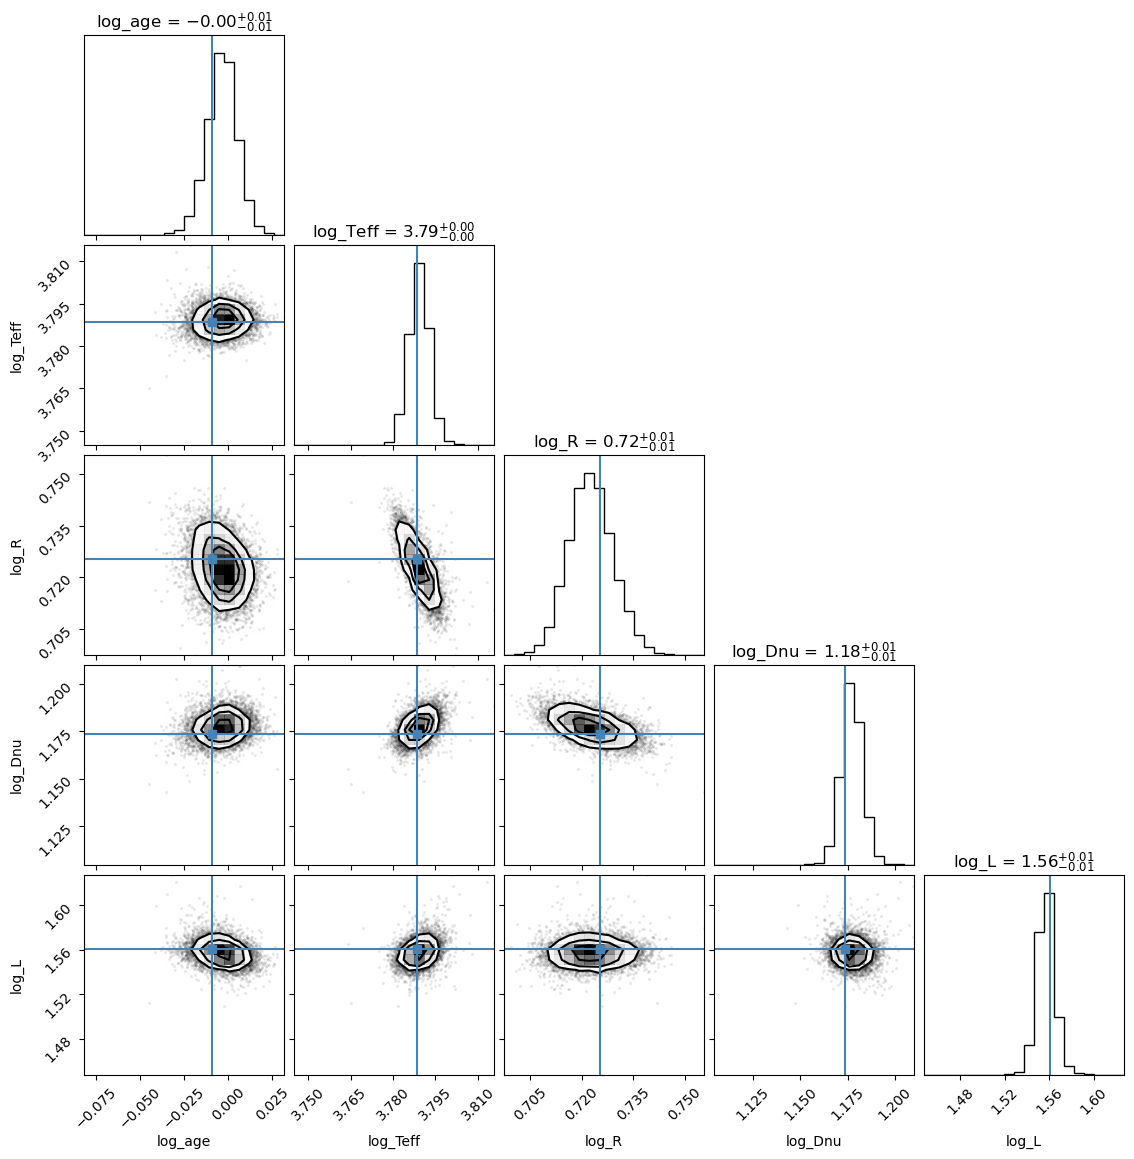

In [ ]:
var_names = ["log_age", "log_Teff", "log_R", "log_Dnu", "log_L"]
for star in range(3):
    coords_ = {"star": star}
    truths_ = {key: truths[key][star] for key in var_names}
    fig = corner(data, var_names=var_names, truths=truths_, coords=coords_, show_titles=True)

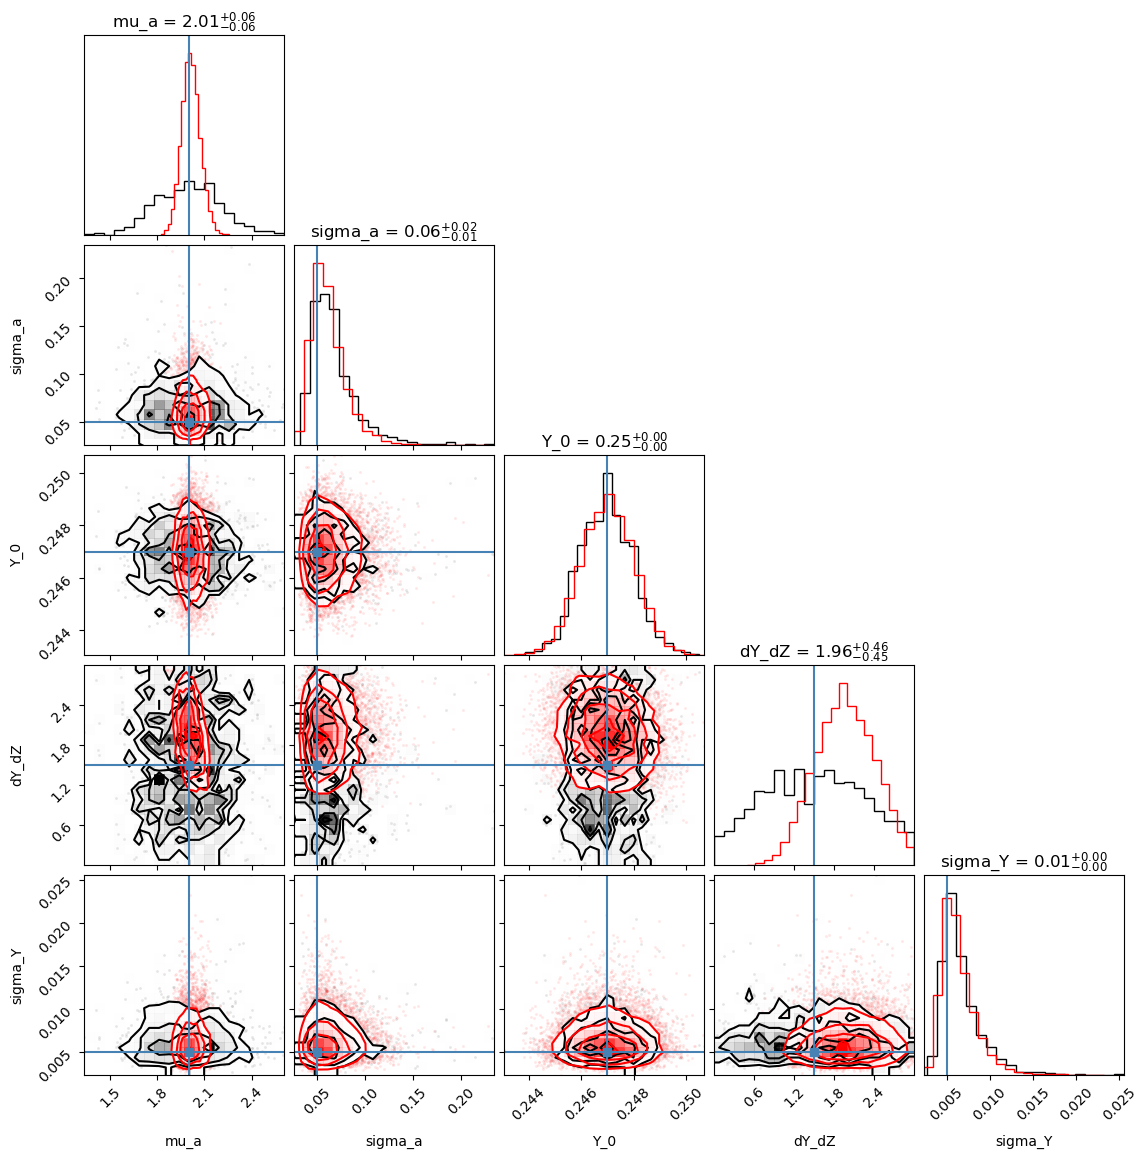

In [ ]:
# limits = [(1.5, 2.5), (0.0, 0.4), (0.244, 0.250), (0.0, 3.0), (0.0, 0.04)]
limits = None
hist_kwargs = dict(density=True)
fig = corner(data, group="prior", var_names=hyperparam_names, range=limits, hist_kwargs=hist_kwargs)

hist_kwargs["color"] = "r"
fig = corner(data, var_names=hyperparam_names, range=limits, hist_kwargs=hist_kwargs,
             color="r", truths=truths, show_titles=True, fig=fig)


Let's look at the fractional error between each posterior sample and the truth. This gives us an idea of the precision and accuracy of our results. Don't expect anything impressive, we are marginalising over `Y` and `a_MLT` after all.

In [ ]:
error = truths - data.posterior
az.summary(error)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
M_H[0]        -0.023  0.094  -0.206    0.144      0.001    0.001    4002.0   
M_H[1]        -0.048  0.095  -0.204    0.131      0.002    0.001    2354.0   
M_H[2]        -0.015  0.093  -0.196    0.151      0.001    0.001    4828.0   
M_H[3]        -0.110  0.081  -0.250    0.026      0.001    0.001    3648.0   
M_H[4]        -0.068  0.086  -0.217    0.077      0.002    0.002    1815.0   
...              ...    ...     ...      ...        ...      ...       ...   
log_numax[45]  0.005  0.011  -0.015    0.028      0.002    0.001      52.0   
log_numax[46] -0.002  0.010  -0.021    0.018      0.000    0.000    2979.0   
log_numax[47] -0.005  0.010  -0.024    0.012      0.000    0.000    6241.0   
log_numax[48]  0.009  0.009  -0.009    0.026      0.000    0.000    3838.0   
log_numax[49] -0.004  0.011  -0.025    0.016      0.001    0.001     425.0   

               ess_tail  r_hat  
M_H[0]           3755.0   1.00  
M_H[1]           4365.0   1.00  
M_H[2]           5279.0   1.00  
M_H[3]           2876.0   1.00  
M_H[4]           2915.0   1.01  
...                 ...    ...  
log_numax[45]     598.0   1.13  
log_numax[46]    4806.0   1.00  
log_numax[47]    7232.0   1.00  
log_numax[48]    6374.0   1.00  
log_numax[49]     118.0   1.03  

[655 rows x 9 columns]

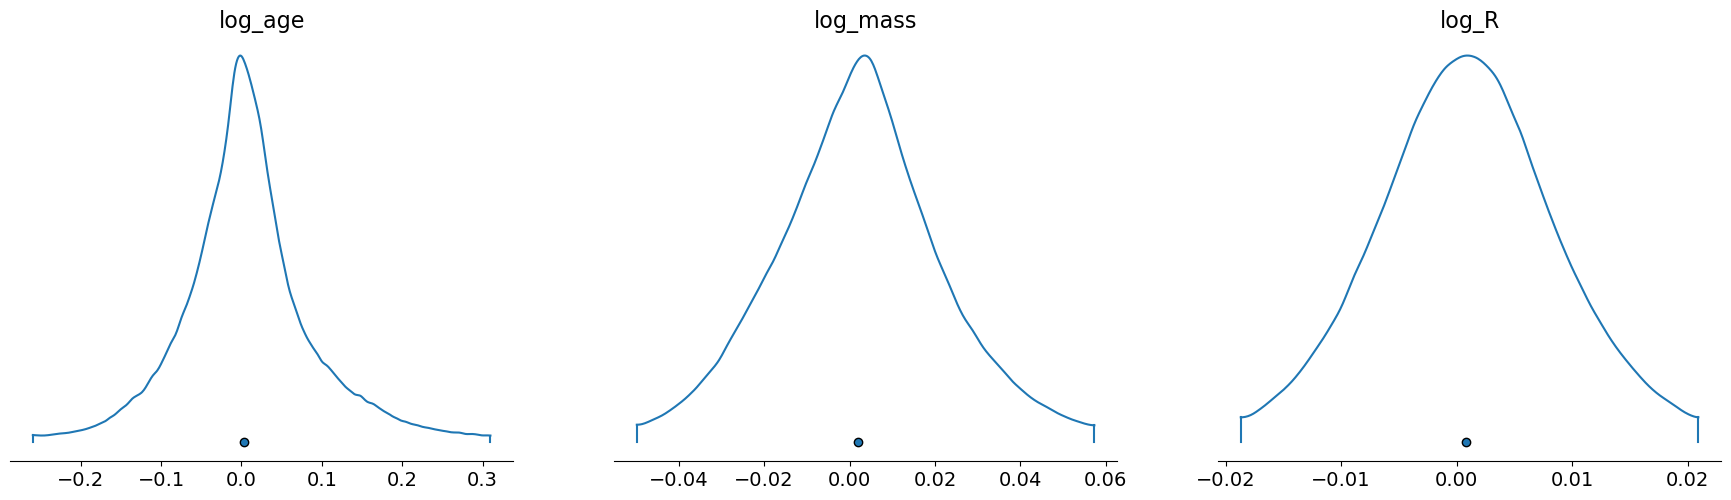

In [39]:
var_names = ["log_age", "log_mass", "log_R"]
az.plot_density(error, var_names=var_names, combine_dims={"star"}, 
                point_estimate="median", hdi_prob=0.98);

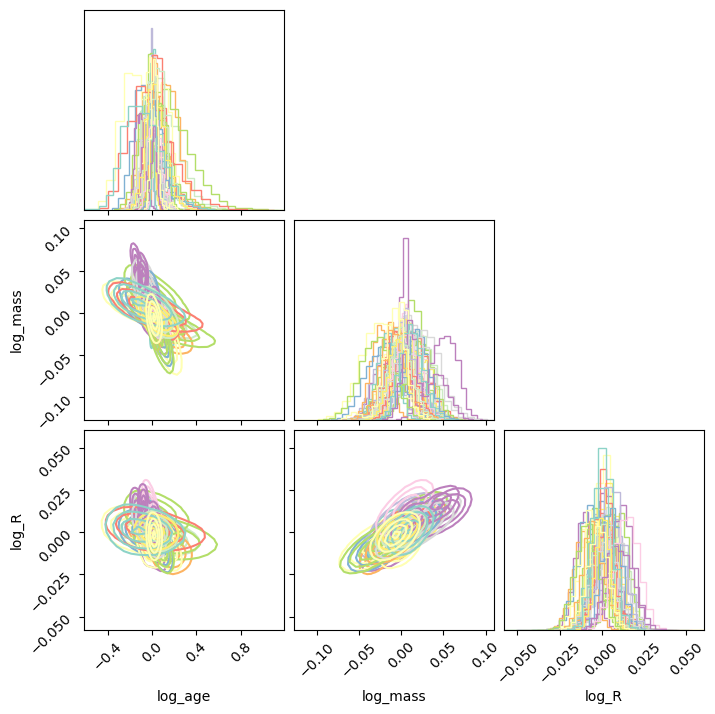

In [40]:
max_stars = num_stars
cmap = colormaps["Set3"]
fig = None
for star in range(max_stars):
    coords_ = {"star": star}
    color = cmap(star%cmap.N)  # loop colors
    fig = corner(error, var_names=var_names, coords=coords_, color=color, fig=fig,
                 plot_datapoints=False, plot_density=False, smooth=1.0)